In [1]:
# exploring options to optimise particle filter params
# by optimising for accuracy over gazebo log

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cbl_particle_filter.filter import load_input_log
from cbl_particle_filter.carpet_map import load_map_from_png
from cbl_particle_filter.filter import Pose, CarpetBasedParticleFilter, offline_playback
from cbl_particle_filter.visualisation import plot_map

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
log_dir = "/home/tfanselo/projects/personal/20210106_cbl/logs/pf_tuning_log_gazebo_20210325"
log_file = f"{log_dir}/localiser_input_log.pickle"
map_png = f"{log_dir}/office_map.png"

In [4]:
carpet = load_map_from_png(map_png, cell_size=0.5)

In [5]:
log = load_input_log(log_file)
start_pose = log[0][2]

In [6]:
def perform_playback(
    log,
    carpet_map,
    seed_pose,
    resample_proportion,
    weight_fn_p,
    odom_pos_noise,
    odom_heading_noise,
    n_particles,
    ):
    """
    Localise over given log, returning a dataframe of localised poses and
    ground truth
    """
    
    np.random.seed(123)
    
    localised_poses = offline_playback(
        input_data = log,
        carpet = carpet,
        seed_pose = seed_pose,
        resample_proportion = resample_proportion,
        weight_fn_p=weight_fn_p,
        odom_pos_noise=odom_pos_noise,
        odom_heading_noise=odom_heading_noise,
        n_particles = n_particles,
    )
    
    
    # convert results to dataframe
    ground_truth_poses = [gt_pose for _, _, gt_pose in log]

    df_data = []
    for ground_truth_pose, localised_pose in zip(ground_truth_poses, localised_poses):
        df_data.append({
            "gt_x":ground_truth_pose.x,
            "gt_y":ground_truth_pose.y,
            "loc_x":localised_pose.x,
            "loc_y":localised_pose.y,
        })
    return pd.DataFrame(df_data)

def plot_results(results_df:pd.DataFrame):    
    plot_map(carpet, show=False)
    plt.plot(results_df.gt_x, results_df.gt_y, color='tab:orange', linewidth=2)
    plt.plot(results_df.loc_x, results_df.loc_y, color='tab:green', marker='o',markersize=3)
    plt.axis('off')
    plt.legend(['ground truth', 'particle filter output'])
    plt.show()
    
def get_playback_error(
    log,
    carpet_map,
    seed_pose,
    resample_proportion,
    weight_fn_p,
    odom_pos_noise,
    odom_heading_noise,
    n_particles,
    plot=False,
    ):
    """
    Report sum squared position error for playback of the given log
    """
    results_df = perform_playback(
        log,
        carpet_map,
        seed_pose,
        resample_proportion,
        weight_fn_p,
        odom_pos_noise,
        odom_heading_noise,
        n_particles,
    )
    position_errors = np.linalg.norm(np.vstack([results_df.loc_x - results_df.gt_x, results_df.loc_y - results_df.gt_y]),axis=0)
    sum_squared_error = sum(np.power(position_errors,2))
    
    if plot:
        plot_results(results_df)

    return sum_squared_error

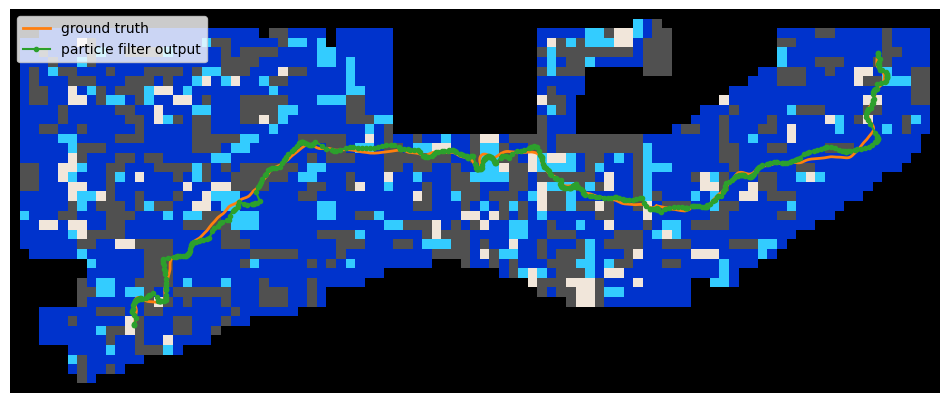

24.59239915503305

In [7]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.05,
    odom_heading_noise=0.05,
    n_particles=500,
    plot=True,
)

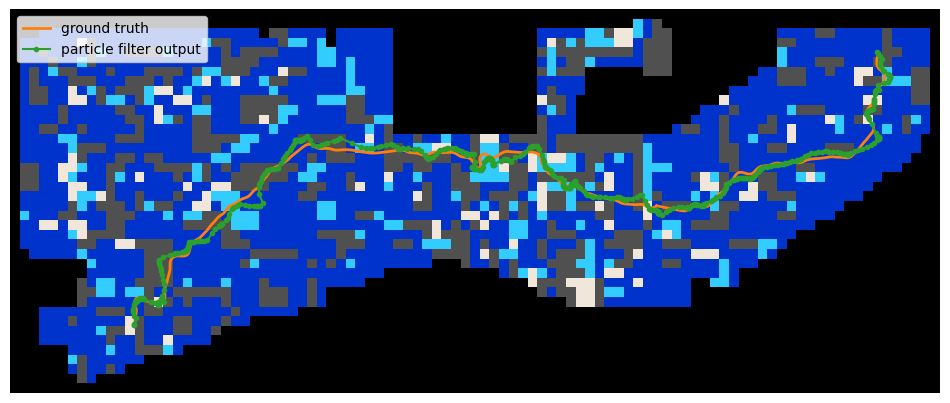

55.237009195496306

In [8]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.1,
    odom_heading_noise=0.05,
    n_particles=500,
    plot=True,
)

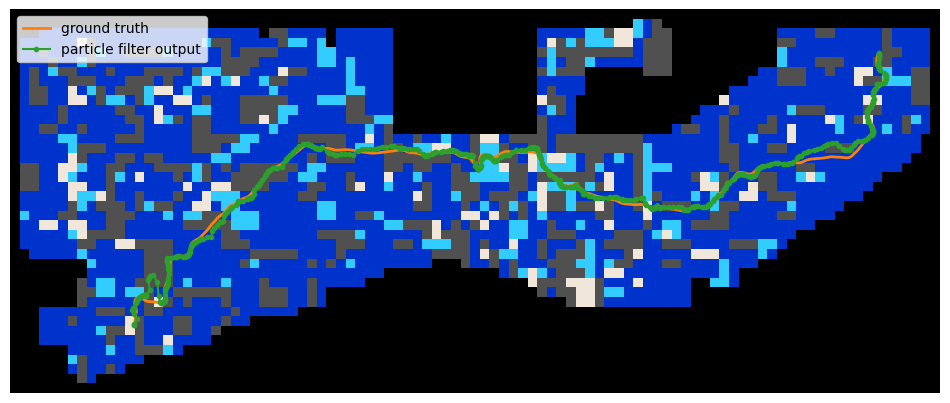

21.635142490065203

In [9]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.01,
    odom_heading_noise=0.05,
    n_particles=500,
    plot=True,
)

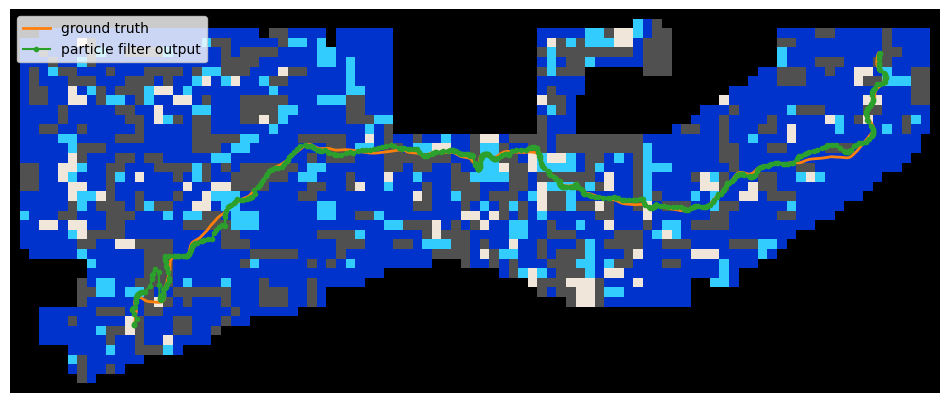

26.06169928507269

In [10]:
get_playback_error(
    log,
    carpet,
    seed_pose=start_pose,
    resample_proportion=0,
    weight_fn_p=0.9,
    odom_pos_noise=0.0,
    odom_heading_noise=0.05,
    n_particles=500,
    plot=True,
)